In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import wget
import zipfile
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
# url = "https://storage.googleapis.com/didow-ml-datasets/a-z-handwritten-data.zip"
# url2 = "https://storage.googleapis.com/didow-ml-datasets/mnist-letter.zip"
# filename = wget.download(url)
# filename2 = wget.download(url2)

In [7]:
# local_zip = ['mnist-letter.zip', 'a-z-handwritten-data.zip']

# for i in local_zip:
#     zip_ref = zipfile.ZipFile(i, 'r')

#     zip_ref.extractall('./Dataset/')
#     zip_ref.close()

In [8]:
az_data = pd.read_csv('Dataset\A_Z Handwritten Data.csv')
emnist_train = pd.read_csv('Dataset\emnist-letters-train.csv')
emnist_test = pd.read_csv('Dataset\emnist-letters-test.csv')

In [9]:
emnist_train_labels = np.array(emnist_train.iloc[:,0].values) - 1
emnist_train_letters = np.array(emnist_train.iloc[:,1:].values)
emnist_test_labels = np.array(emnist_test.iloc[:,0].values) - 1
emnist_test_letters = np.array(emnist_test.iloc[:,1:].values)
az_data_labels = np.array(az_data.iloc[:,0].values)
az_data_letters = np.array(az_data.iloc[:,1:].values)

In [10]:
def reshape_normalize(data):
    data = data.astype('float32') / 255.0
    data = data.reshape(-1, 28, 28, 1)
    return data

In [11]:
def reshape_rotate(data):
    data = data.reshape(28,28)
    data = np.fliplr(data)
    data = np.rot90(data)
    return data

In [12]:
emnist_train_letters = np.apply_along_axis(reshape_rotate, 1, emnist_train_letters)
emnist_test_letters = np.apply_along_axis(reshape_rotate, 1, emnist_test_letters)

In [13]:
az_data_letters = az_data_letters.reshape(len(az_data_letters), 28, 28)

In [14]:
print(az_data_letters.shape, emnist_test_letters.shape, emnist_train_letters.shape)

(372450, 28, 28) (14799, 28, 28) (88799, 28, 28)


In [15]:
letters = np.vstack([emnist_train_letters, emnist_test_letters, az_data_letters])
labels = np.hstack([emnist_train_labels, emnist_test_labels, az_data_labels])

In [16]:
print(letters.shape, labels.shape)

(476048, 28, 28) (476048,)


In [17]:
x_train, x_val, y_train, y_val = train_test_split(letters,
                                                  labels,
                                                  test_size=0.2,
                                                  random_state=42)

In [18]:
x_train = reshape_normalize(x_train)
x_val = reshape_normalize(x_val)

In [19]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(380838, 28, 28, 1) (380838,) (95210, 28, 28, 1) (95210,)


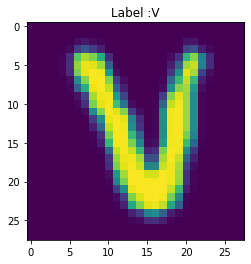

In [20]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
           'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

def show_image(image, label):
    image = image.reshape([28, 28])
    plt.title('Label :' + letters[label])
    plt.imshow(image)

n = random.randint(0, len(emnist_train_letters))
show_image(emnist_train_letters[n], emnist_train_labels[n])


In [21]:
y_train = np_utils.to_categorical(y_train, 26)
y_val = np_utils.to_categorical(y_val, 26)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                                 
                                                        

In [26]:
myCallbacks = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01)

In [28]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, callbacks=[myCallbacks])

Epoch 1/50
9521/9521 [==============================] - 24s 3ms/step - loss: 0.0227 - accuracy: 0.9913 - val_loss: 0.1150 - val_accuracy: 0.9763
Epoch 2/50
9521/9521 [==============================] - 25s 3ms/step - loss: 0.0209 - accuracy: 0.9921 - val_loss: 0.1236 - val_accuracy: 0.9768
Epoch 3/50
9521/9521 [==============================] - 24s 3ms/step - loss: 0.0197 - accuracy: 0.9924 - val_loss: 0.1286 - val_accuracy: 0.9773


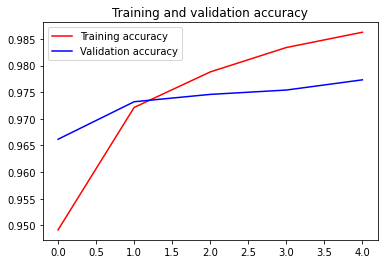

<Figure size 432x288 with 0 Axes>

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

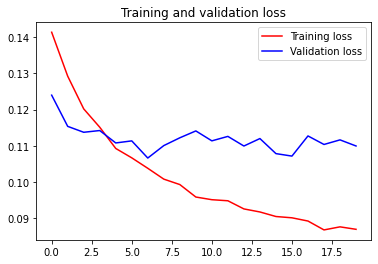

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_val, y_val, verbose = 2)

print("Test Loss: ",test_loss)
print("Test Accuracy: ",test_accuracy)

2976/2976 - 3s - loss: 0.1100 - accuracy: 0.9714 - 3s/epoch - 1ms/step
Test Loss:  0.10995586961507797
Test Accuracy:  0.9713685512542725


1/1 [==============================] - 0s 11ms/step


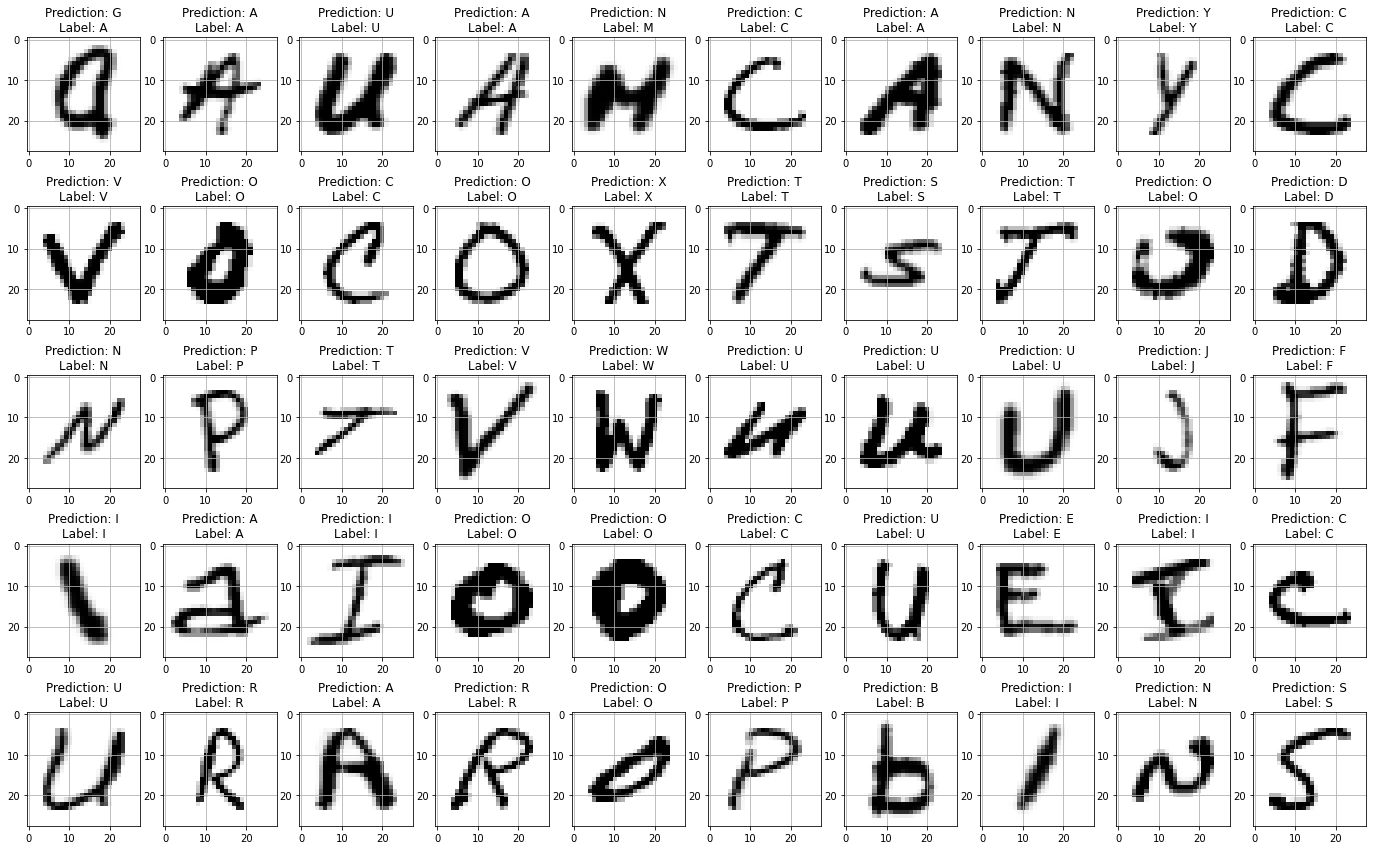

In [ ]:
fig, axes = plt.subplots(5, 10, figsize=(24, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    n = random.randint(0, len(x_val))
    img = np.reshape(x_val[n], (28, 28))
    # img = np.fliplr(img)
    # img = np.rot90(img)
    ax.imshow(img, cmap="Greys")
    # reshapng it for passing into model for prediction
    img_final = np.reshape(img, (1, 28, 28, 1))
    pred = letters[np.argmax(model.predict(img_final))]
    ax.set_title("Prediction: {}\nLabel: {}".format(
        pred, letters[y_val[n]]))
    ax.grid()


In [ ]:
model_version = '2'
model_name = 'combine'
file_name = 'combine_model'
file_path = "./Model/{}/{}/{}.h5".format(model_name, model_version, file_name)
model.save(file_path)